<b> Relevant to our recommender building, just for fun, let's explore the connection between the descriptions for our movies and their genres. We'll train a classifier to predict the genres of a movie based on its overview. First, we'll train independent logistic regressors for each of the 20 classes/genres in our dataset. Then, we'll explore the classifier chain which predicts the probabilities for subsequent classes based on those preceding. Finally, we'll use an MLP and RNN to provide more flexibility for our model. The metric used throghout is cross entropy or log loss.

In [ ]:
!wget "https://raw.githubusercontent.com/lexie21/recommender/main/model/movies_data/imdb_folder/movies_metadata.csv"

--2024-09-01 09:08:32--  https://raw.githubusercontent.com/lexie21/recommender/main/model/movies_data/imdb_folder/movies_metadata.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34445126 (33M) [text/plain]
Saving to: ‘movies_metadata.csv’

movies_metadata.csv 100%[===================>]  32.85M  --.-KB/s    in 0.1s    

2024-09-01 09:08:32 (263 MB/s) - ‘movies_metadata.csv’ saved [34445126/34445126]



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import ClassifierChain, MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV
from ast import literal_eval
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression

In [ ]:
movies = pd.read_csv("movies_metadata.csv")

<ipython-input-3-472343648836>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv("movies_metadata.csv")


In [ ]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
keep_col = ["overview","genres"]
data = movies[keep_col]

In [ ]:
data.head()

,overview,genres
0,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,"Cheated on, mistreated and stepped on, the wom...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]"


In [ ]:
encoder = MultiLabelBinarizer()

def destring(var):
      df = data.copy()
      def generate_list(x):
          if isinstance(x, list):
              names = [i["name"] for i in x]
              return names
          return []

      def sanitize(x):
          if isinstance(x, list):
              return [str.lower(i.replace(" ", "")) for i in x]
          else:
              if isinstance(x, str):
                  return str.lower(x.replace(" ", ""))
              else:
                  return ''

      df = df.dropna()
      df[var] = df[var].fillna('[]').apply(literal_eval)
      df[var] = df[var].apply(generate_list).apply(sanitize)
      encoded = encoder.fit_transform(df[var])
      encoded_df = pd.DataFrame(encoded,columns=encoder.classes_)
      df = pd.merge(df, encoded_df, left_index=True, right_index=True)
      return df, encoder


df, encoder = destring("genres")

In [ ]:
df.head()

,overview,genres,action,adventure,animation,aniplex,brostatv,carouselproductions,comedy,crime,...,romance,sciencefiction,sentaifilmworks,telescenefilmgroupproductions,thecartel,thriller,tvmovie,visionviewentertainment,war,western
0,"Led by Woody, Andy's toys live happily in his ...","[animation, comedy, family]",0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,When siblings Judy and Peter discover an encha...,"[adventure, fantasy, family]",0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A family wedding reignites the ancient feud be...,"[romance, comedy]",0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,"Cheated on, mistreated and stepped on, the wom...","[comedy, drama, romance]",0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,Just when George Banks has recovered from his ...,[comedy],0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
encoder.classes_

array(['action', 'adventure', 'animation', 'aniplex', 'brostatv',
       'carouselproductions', 'comedy', 'crime', 'documentary', 'drama',
       'family', 'fantasy', 'foreign', 'gohands', 'history', 'horror',
       'mardockscrambleproductioncommittee', 'music', 'mystery',
       'odysseymedia', 'pulserproductions', 'roguestate', 'romance',
       'sciencefiction', 'sentaifilmworks',
       'telescenefilmgroupproductions', 'thecartel', 'thriller',
       'tvmovie', 'visionviewentertainment', 'war', 'western'],
      dtype=object)

In [ ]:
df[df["overview"].isna()].count()
df = df.dropna()
df[df["overview"].isna()]

,overview,genres,action,adventure,animation,aniplex,brostatv,carouselproductions,comedy,crime,...,romance,sciencefiction,sentaifilmworks,telescenefilmgroupproductions,thecartel,thriller,tvmovie,visionviewentertainment,war,western


In [ ]:
# arbitrarily impose constraint on length of overview to be considered meaningful
df = df[df["overview"].apply(len) > 45]

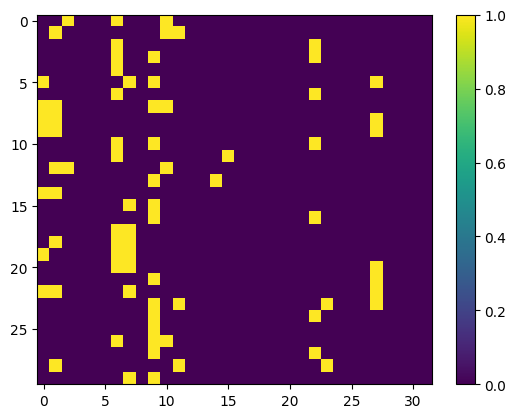

In [ ]:
plt.imshow(df.drop(["overview","genres"],axis=1).values[:30])
plt.colorbar()

In [ ]:
# for movies 0 to 30, classes 16-22 and 28-30 are dominated by other classes => reminder that dataset is very imbalanced, the rare classes are:
df.drop(["overview","genres"],axis=1).columns[15:]

Index(['horror', 'mardockscrambleproductioncommittee', 'music', 'mystery',
       'odysseymedia', 'pulserproductions', 'roguestate', 'romance',
       'sciencefiction', 'sentaifilmworks', 'telescenefilmgroupproductions',
       'thecartel', 'thriller', 'tvmovie', 'visionviewentertainment', 'war',
       'western'],
      dtype='object')

In [ ]:
# drop genres with only 1 counts
df.drop(["overview","genres"],axis=1).sum(axis=0)

,0
action,6385
adventure,3385
animation,1840
aniplex,1
brostatv,1
carouselproductions,1
comedy,12485
crime,4170
documentary,3730
drama,19474


In [ ]:
y = df.drop(["overview","genres"],axis=1)

In [ ]:
reduced_y = y.T[y.sum(axis=0) > 1].T

In [ ]:
reduced_y.sum(axis=0) # heavily imbalanced towards drama, comedy and thriller

,0
action,6385
adventure,3385
animation,1840
comedy,12485
crime,4170
documentary,3730
drama,19474
family,2660
fantasy,2217
foreign,1550


In [ ]:
df = pd.merge(df[["overview","genres"]],reduced_y,left_index=True,right_index=True)
final_df = df[df.drop(["overview","genres"],axis=1).sum(axis=1) > 0]

In [ ]:
final_df.columns

Index(['overview', 'genres', 'action', 'adventure', 'animation', 'comedy',
       'crime', 'documentary', 'drama', 'family', 'fantasy', 'foreign',
       'history', 'horror', 'music', 'mystery', 'romance', 'sciencefiction',
       'thriller', 'tvmovie', 'war', 'western'],
      dtype='object')

In [ ]:
X = final_df["overview"]

In [ ]:
y = final_df.drop(["overview","genres"],axis=1)

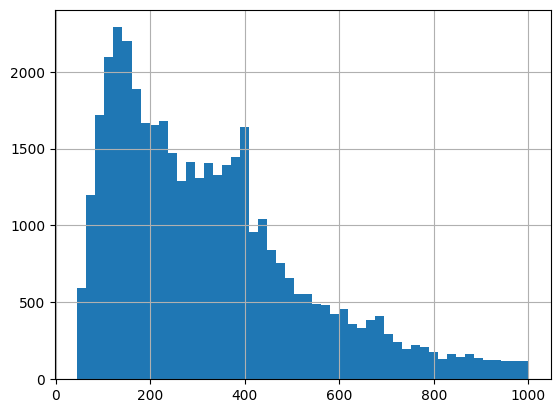

In [ ]:
# length distribution of overview
plt.hist(X.apply(len),bins=50);
plt.grid(True);

In [ ]:
X.apply(len).describe()

,overview
count,41097.000000
mean,326.646276
std,203.173754
min,46.000000
25%,162.000000
50%,287.000000
75%,431.000000
max,1000.000000


In [ ]:
# train and test set
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=2111,test_size=0.2,shuffle=True)

In [ ]:
# check label distributions
list(zip(y.columns, np.sum(y,axis=0)/len(y), np.sum(y_train,axis=0)/y_train.shape[0], np.sum(y_test,axis=0)/y_test.shape[0]))

[('action', 0.15536413850159378, 0.15494114426498767, 0.1570559610705596),
 ('adventure', 0.08236610944837823, 0.08185053380782918, 0.08442822384428224),
 ('animation', 0.04477212448597221, 0.045046689174803055, 0.04367396593673966),
 ('comedy', 0.3037934642431321, 0.30468108404051464, 0.30024330900243307),
 ('crime', 0.10146726038396964, 0.10146911214526873, 0.10145985401459855),
 ('documentary', 0.09076088278949802, 0.09027587675274508, 0.0927007299270073),
 ('drama', 0.4738545392607733, 0.4731271101377863, 0.4767639902676399),
 ('family', 0.06472491909385113, 0.06569942513003012, 0.06082725060827251),
 ('fantasy', 0.053945543470326304, 0.053745779724427414, 0.05474452554744526),
 ('foreign', 0.03771564834416138, 0.037625087447151505, 0.03807785888077859),
 ('history', 0.0326787843394895, 0.034248866989080515, 0.026399026763990266),
 ('horror', 0.11054334866291944, 0.1112023603126806, 0.10790754257907542),
 ('music', 0.03744798890429958, 0.037807585850290475, 0.03600973236009732),
 (

In [ ]:
tfv = TfidfVectorizer(analyzer="word",stop_words="english",token_pattern=r'([a-zA-Z]{1,})')

In [ ]:
tfv.fit(X_train)

TfidfVectorizer(stop_words='english', token_pattern='([a-zA-Z]{1,})')

In [ ]:
tfv.get_feature_names_out()[:100]
# ToDo: need better features

array(['aa', 'aaaron', 'aab', 'aachan', 'aadhavan', 'aadhi', 'aakash',
       'aake', 'aalavandhan', 'aalst', 'aames', 'aamir', 'aan',
       'aanmodderfakker', 'aapeli', 'aarakshan', 'aarne', 'aarno',
       'aaron', 'aarons', 'aarp', 'aarti', 'aasen', 'aashish', 'aasia',
       'aati', 'aatish', 'ab', 'aba', 'ababa', 'abacco', 'aback',
       'abaddon', 'abagnale', 'abahachi', 'abalaba', 'abalone', 'abandon',
       'abandoned', 'abandoning', 'abandonment', 'abandons', 'abar',
       'abas', 'abatcha', 'abates', 'abati', 'abb', 'abba', 'abbaji',
       'abbas', 'abbaseya', 'abbasi', 'abbass', 'abbe', 'abberline',
       'abbes', 'abbess', 'abbey', 'abbia', 'abbie', 'abbot', 'abbott',
       'abby', 'abc', 'abdallah', 'abdel', 'abdelatif', 'abdelhakim',
       'abdelilah', 'abdicated', 'abdicates', 'abdicating', 'abdication',
       'abdominal', 'abdou', 'abdu', 'abduct', 'abducted', 'abductee',
       'abducting', 'abduction', 'abductions', 'abductor', 'abductors',
       'abducts', 

In [ ]:
X_train_tfv = tfv.transform(X_train)
X_test_tfv = tfv.transform(X_test)

In [ ]:
svd = TruncatedSVD(n_components = 130)
X_train_svd = svd.fit_transform(X_train_tfv)
X_test_svd = svd.transform(X_test_tfv)

<b> Done with preprocessing. Now first try with linear classifiers, we'll use the very simply logistic regression in this case to predict the probabilities for each class independently of other classes.

In [ ]:
# independently training a logreg for each class, another way to do this is to use the OneVsRest approach builtin in sklearn
probs = np.zeros(y_test.shape)
for i,cls in enumerate(y_train.columns):
  reg = LogisticRegression()
  reg.fit(X_train_svd, y_train.iloc[:,i])
  probs[:,i] = reg.predict_proba(X_test_svd)[:,1]

In [ ]:
log_loss(y_test,probs)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


5.565024470712377

<b> Can we improve on the loss if using classifier chain instead? As its name suggests, a classifier chain predicts the probabilities for the later classes based on those of the previous classes, capturing any dependency between them in the process.

In [ ]:
log_reg = LogisticRegression()
classifier = ClassifierChain(log_reg)
classifier.fit(X_train_svd, y_train)

ClassifierChain(base_estimator=LogisticRegression())

In [ ]:
pred_logreg = classifier.predict_proba(X_test_svd)

In [ ]:
pred_logreg

array([[0.16840338, 0.05274278, 0.04240512, ..., 0.0198288 , 0.05962031,
        0.03392632],
       [0.15256836, 0.04073609, 0.04529512, ..., 0.01628802, 0.06314505,
        0.03163209],
       [0.17614608, 0.05992775, 0.04054546, ..., 0.01982361, 0.05748699,
        0.03519791],
       ...,
       [0.12631313, 0.05215675, 0.03732938, ..., 0.01935514, 0.06042494,
        0.03454203],
       [0.14494616, 0.04427553, 0.03667957, ..., 0.02477276, 0.06049832,
        0.04104616],
       [0.14223246, 0.03941257, 0.04234686, ..., 0.02021692, 0.06271565,
        0.03915933]])

In [ ]:
log_loss(y_test, pred_logreg)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


5.70275068039993

<b> We seem to run out of luck with the simple classifiers above. Let's up our games and try two simple neural networks. We'll use sigmoid for the output layer and binary cross entropy for the loss function.

In [ ]:
import keras
from tensorflow.keras.optimizers import Adam

In [ ]:
X = final_df["overview"]
y = final_df.drop(["overview","genres"],axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=2111,test_size=0.2)

In [ ]:
# on the entire dataset
tfv = TfidfVectorizer(analyzer="word",stop_words="english")
X_train_tfv = tfv.fit_transform(X_train)
X_test_tfv = tfv.transform(X_test)

In [ ]:
svd = TruncatedSVD(n_components=150,)
X_train_svd = svd.fit_transform(X_train_tfv)
X_test_svd = svd.transform(X_test_tfv)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(50, input_shape=(X_train_svd.shape[1:])),
    keras.layers.Dense(20, activation="sigmoid")
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(loss="binary_crossentropy",optimizer = keras.optimizers.Adam(learning_rate=0.01))

In [ ]:
history = model.fit(X_train_svd, y_train, epochs=10, validation_data=(X_test_svd,y_test))

Epoch 1/10
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3171 - val_loss: 0.2924
Epoch 2/10
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2938 - val_loss: 0.2934
Epoch 3/10
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2933 - val_loss: 0.2927
Epoch 4/10
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2924 - val_loss: 0.2926
Epoch 5/10
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2926 - val_loss: 0.2924
Epoch 6/10
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2905 - val_loss: 0.2925
Epoch 7/10
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.2921 - val_loss: 0.2931
Epoch 8/10
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.2903 - val_loss: 0.2927
Epoch 9/10
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2924 - val_loss: 0.2924
Epoch 10/10
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2913 - val_loss: 0.2925


In [ ]:
# use an RNN
model2 = keras.models.Sequential([
keras.layers.SimpleRNN(20, return_sequences=True, input_shape=(X_train_svd.shape[1],1)),
keras.layers.SimpleRNN(20),
keras.layers.Dense(20, activation="sigmoid")
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model2.compile(loss="binary_crossentropy",optimizer = keras.optimizers.Adam(learning_rate=0.01))

In [ ]:
history2 = model2.fit(X_train_svd, y_train, epochs=2, validation_data=(X_test_svd, y_test))

Epoch 1/2
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 62s 61ms/step - loss: 0.2938 - val_loss: 0.2925
Epoch 2/2
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 80s 77ms/step - loss: 0.2930 - val_loss: 0.2923


In [ ]:
# predict genre of an overview and go :D
sample = 100
print(X[sample])
predictions = model.predict(X_test_svd[[sample]])


A single and lonely woman finds the seemingly perfect man to date, but soon regrets it when his deranged and possessive other personality emerges and worst still, she cannot convince anyone else of his Jekyll/Hyde true nature.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


In [ ]:
predictions

array([[0.15912864, 0.09309348, 0.03054715, 0.2863103 , 0.10168633,
        0.07845808, 0.50235415, 0.05828898, 0.05444017, 0.03595791,
        0.0273453 , 0.12581915, 0.02791269, 0.05553377, 0.18579563,
        0.06724565, 0.18221775, 0.02360947, 0.03020378, 0.02296568]],
      dtype=float32)

In [ ]:
predictions2 = model2.predict(X_test_svd[[sample]])
predictions2

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


array([[0.14699817, 0.0596124 , 0.04762222, 0.29537016, 0.14164673,
        0.11429958, 0.40133467, 0.06909429, 0.06173861, 0.03169628,
        0.02500871, 0.10096799, 0.03376788, 0.06941658, 0.163523  ,
        0.07118466, 0.20677288, 0.01649095, 0.02079862, 0.02840757]],
      dtype=float32)

In [ ]:
# probs look very similar for 2 models
print(np.argsort(predictions[0])[::-1])
print(np.argsort(predictions2[0])[::-1])

[ 6  3 14 16  0 11  4  1  5 15  7 13  8  9  2 18 12 10 17 19]
[ 6  3 16 14  0  4  5 11 15 13  7  8  1  2 12  9 19 10 18 17]


<b> It is obvious that the probabilities estimated from both models look very similar. This is because of the class imbalance problem mentioned at the beginning. The predictions are heavility geared towards the 3 classes of comedy, drama and thriller. We would need to refine our dataset further in order for any training to work its full effect. Task for the future!